In [2]:
from ray import tune
import pandas as pd
import numpy as np
import os
import torch
# visualization:
import seaborn as sns
import matplotlib.pyplot as plt
# self-written
import DL_functions as dl
from importlib import reload
reload(dl)

<module 'DL_functions' from '/Users/tsung_macbook/Dropbox/DL/final/code/DL_functions.py'>

### Baseline

In [57]:
default_model = torch.load("output/FTT_default_model_3cv.pt", map_location="cpu")
default_model["1"].keys()

dict_keys(['best_bac_wts', 'best_acc_wts', 'validate_acc', 'validate_bac', 'validate_losses', 'train_acc', 'train_bac', 'train_losses'])

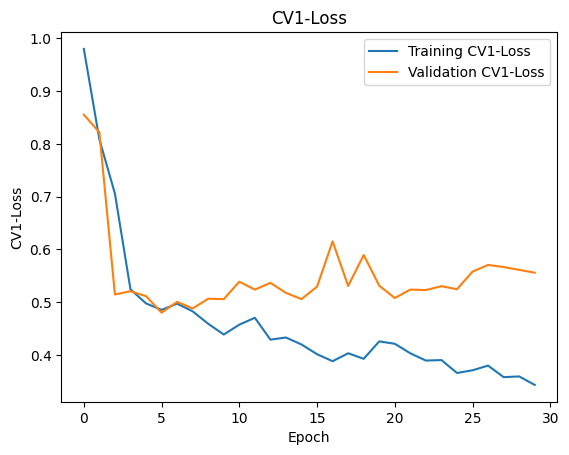

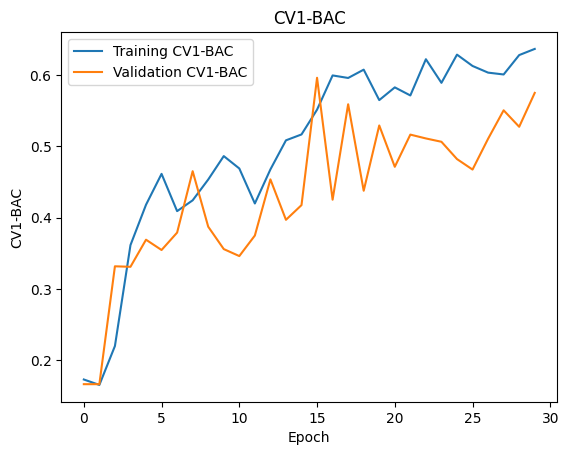

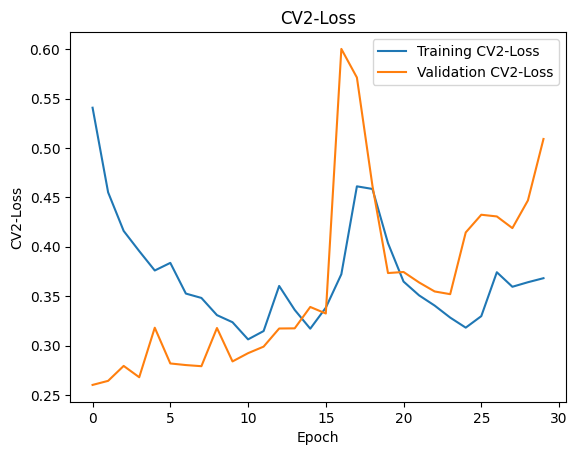

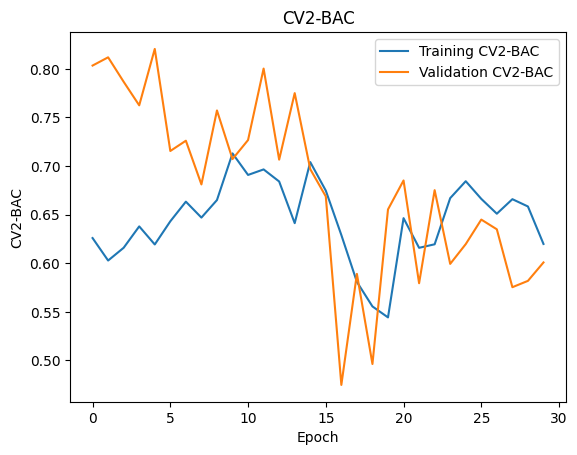

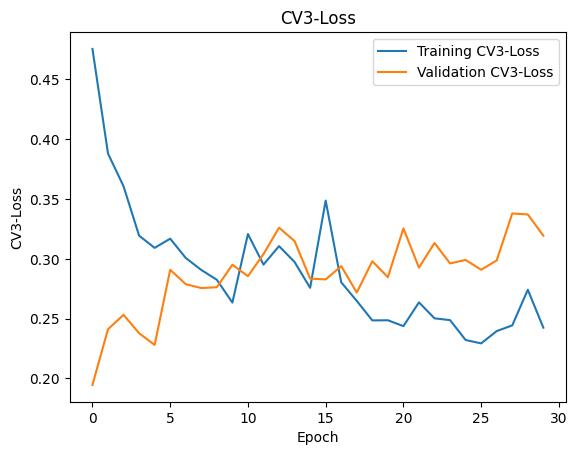

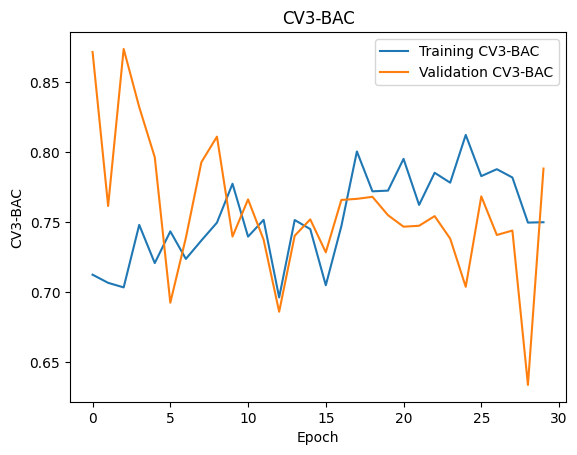

In [62]:
top=30
for i in range(1,4):
    i = str(i)
    dl.plt_learning_curve(default_model[i]["train_losses"][:top], default_model[i]["validate_losses"][:top], f'CV{i}-Loss')
    # plt_learning_curve(default_model[i]["train_acc"][:top], default_model[i]["validate_acc"][:top], f'CV{i}-Accuracy')
    dl.plt_learning_curve(default_model[i]["train_bac"][:top], default_model[i]["validate_bac"][:top], f'CV{i}-BAC')
# > choose cv1


### Round 1
```
search_space = {
     "lr": tune.loguniform(1e-4, 1e-1),   # learning rate
     "wd": tune.loguniform(1e-4, 1e-1),   # wegith decay
     "batch_size": tune.choice([16, 32, 64, 128])
 }
```

In [5]:
os.listdir("output/round2/")

['cv_2_RayTune.pt',
 'cv_2_RayTune_df.pt',
 'cv_1_RayTune_df.pt',
 'cv_3_RayTune.pt',
 'cv_3_RayTune_df.pt',
 'cv_1_RayTune.pt']

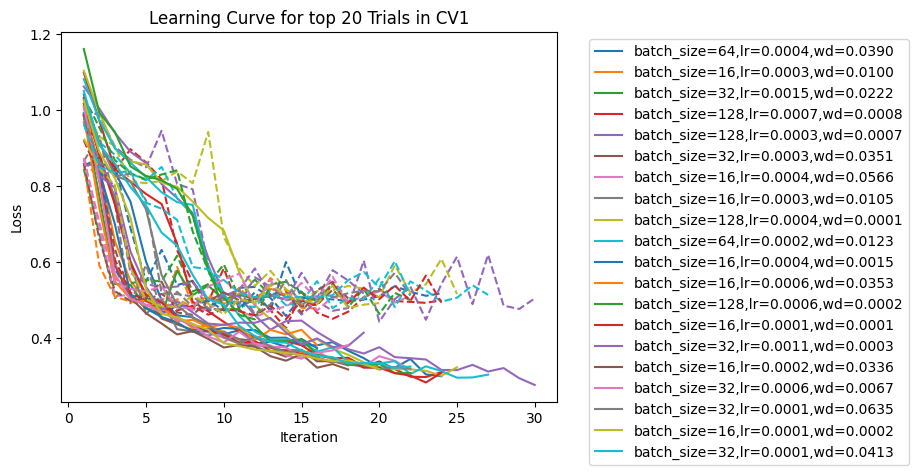

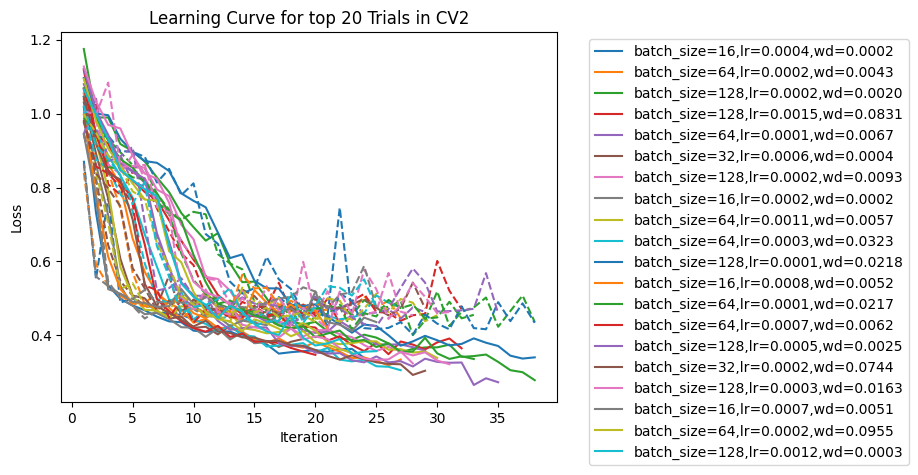

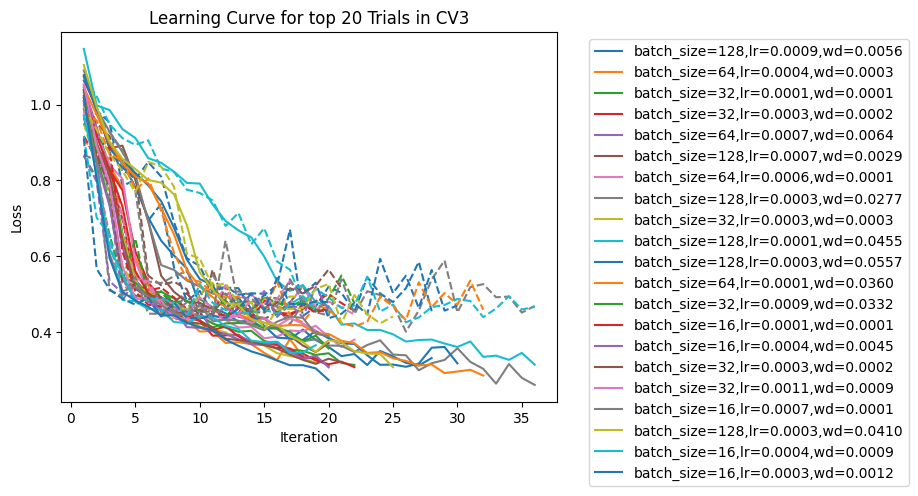

In [123]:
top=20
for i in range(1,4):
    raw = torch.load(f"output/round1/cv_{i}_RayTune.pt") 
    all_reports = raw.trial_dataframes   # get tune.report() of all iterations
    df = torch.load(f"output/round1/cv_{i}_RayTune_df.pt").sort_values("val_loss")
    # get the ID of best trials:
    top_labels = df.experiment_tag.apply(lambda x:"_".join(x.split("_")[1:]))[:top]
    fig, ax = plt.subplots()
    j = 0
    for key in all_reports.keys():
        label = "_".join(key.split('/')[-1].split('_')[-4:-2])
        if label in list(top_labels): # if in top trials, plot it
            color = f"C{j}"
            j += 1
            x = all_reports[key]["iterations_since_restore"]
            train_loss = all_reports[key]['train_loss']
            val_loss = all_reports[key]['val_loss']
            ax.plot(x, train_loss, label=label,
                    color=color)  # Use dashed line for train loss
            ax.plot(x, val_loss, color=color, linestyle="--")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title(f"Learning Curve for top {top} Trials in CV{i}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

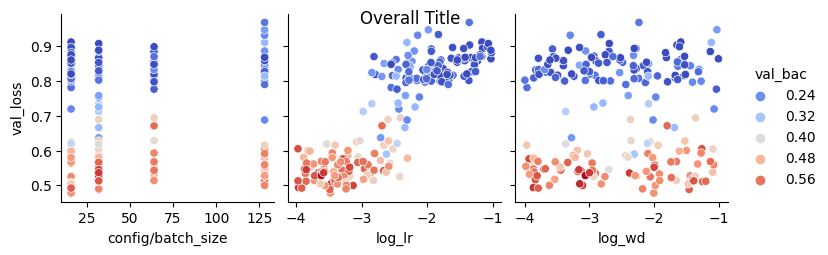

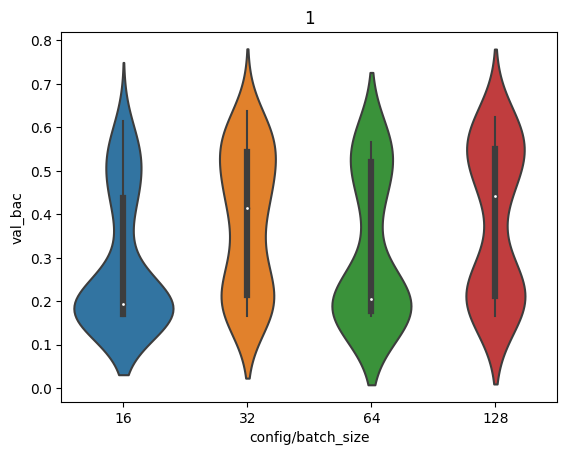

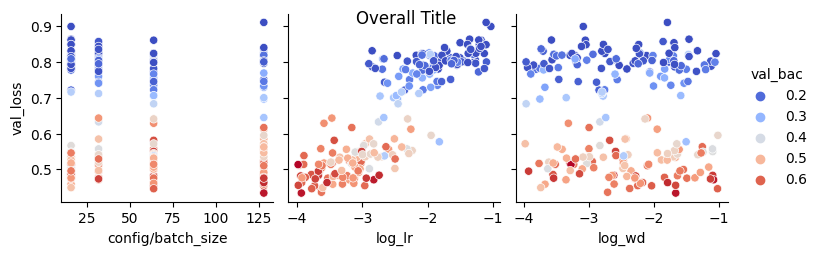

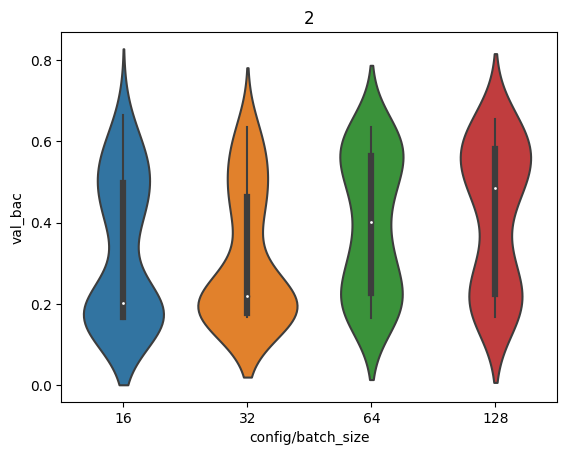

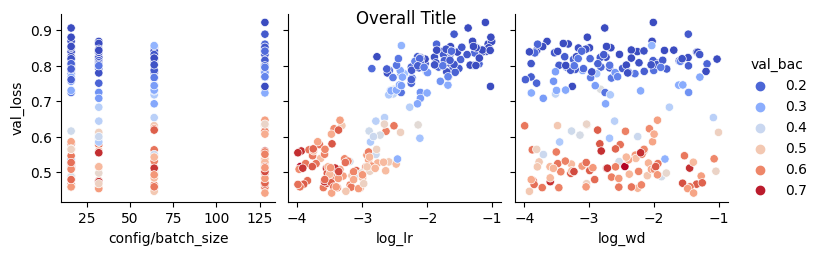

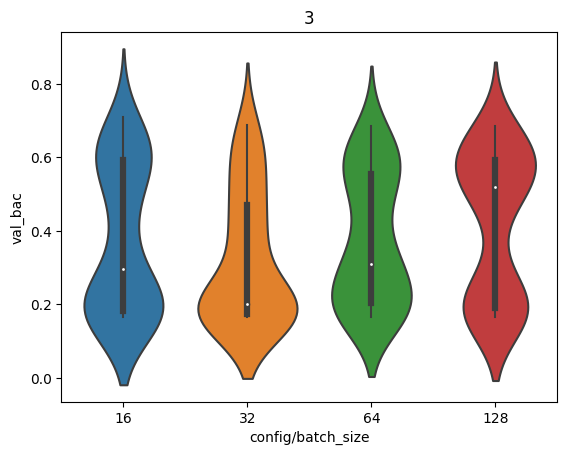

In [126]:
for i in range(1,4):
    df = torch.load(f"output/round1/cv_{i}_RayTune_df.pt")
    df = df.assign(log_lr = np.log10(df["config/lr"]),
          log_wd = np.log10(df["config/wd"])
         )
    sns.pairplot(data=df, x_vars=["config/batch_size","log_lr", "log_wd"], 
             y_vars="val_loss", hue="val_bac", palette="coolwarm")
    plt.show()
    sns.violinplot(x="config/batch_size", y="val_bac", data=df).set(title=str(i))
    plt.show()

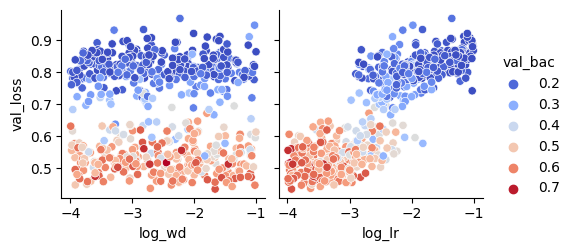

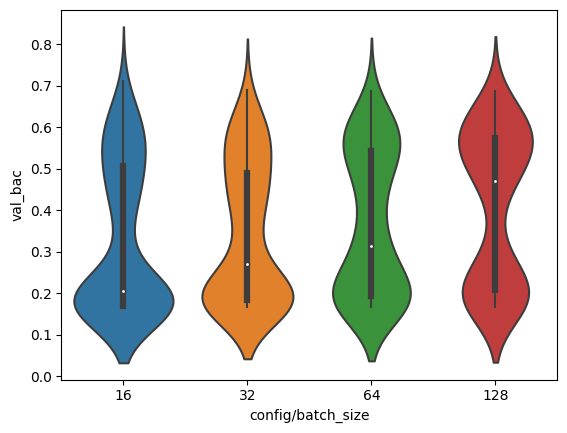

In [133]:
# For all:
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round1/cv_{i}_RayTune_df.pt")], axis=0)
df = df.assign(log_lr = np.log10(df["config/lr"]), log_wd=np.log10(df["config/wd"]))
sns.pairplot(data=df, x_vars=["log_wd","log_lr"], 
             y_vars="val_loss", hue="val_bac", palette="coolwarm")
plt.show()
sns.violinplot(x="config/batch_size", y="val_bac", data=df)
plt.show()

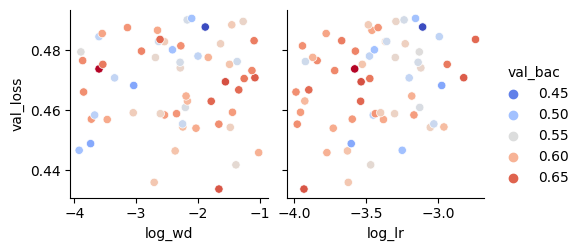

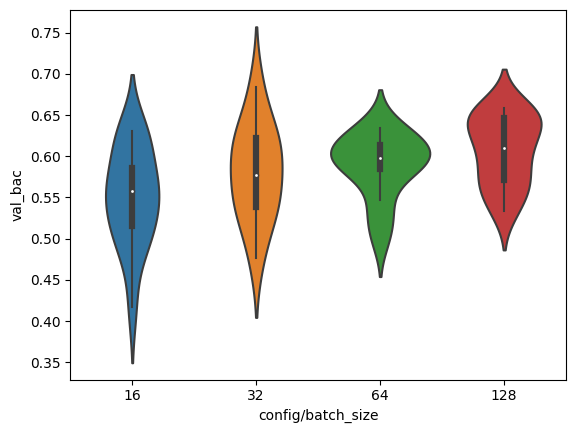

In [74]:
# For top 10%:
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round1/cv_{i}_RayTune_df.pt")], axis=0)
df = df.assign(log_lr = np.log10(df["config/lr"]), log_wd=np.log10(df["config/wd"]))
df = df.sort_values("val_loss").iloc[:df.shape[0]//10,]
sns.pairplot(data=df, x_vars=["log_wd","log_lr"], 
             y_vars="val_loss", hue="val_bac", palette="coolwarm")
plt.show()
sns.violinplot(x="config/batch_size", y="val_bac", data=df)
plt.show()

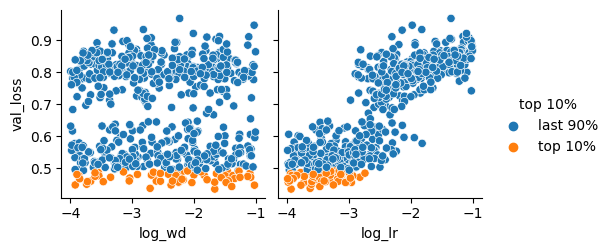

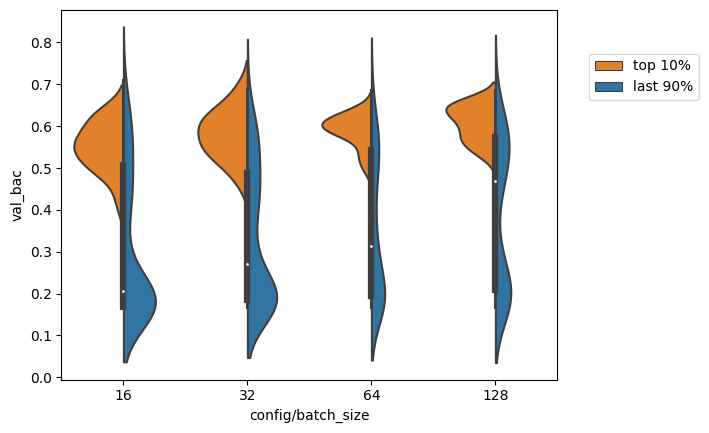

In [119]:
## Grouped by top 10% and the rest
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round1/cv_{i}_RayTune_df.pt")], axis=0)
df = df.assign(log_lr=np.log10(df["config/lr"]), log_wd=np.log10(df["config/wd"]))

# Identify the top 10% with lowest validation loss
top10_val_loss = df.sort_values("val_loss").iloc[:int(len(df)*0.1)]
df["top 10%"] = np.where(df.index.isin(top10_val_loss.index), "top 10%", "last 90%")
# Create the pairplot with color based on validation loss
sns.pairplot(data=df, x_vars=["log_wd","log_lr"], 
             y_vars="val_loss", hue="top 10%")
plt.show()

# Create the violin plot with color based on validation BAC
sns.violinplot(x="config/batch_size", y="val_bac", data=df, palette=["C1", "C0"],
               hue="top 10%", split=True, hue_order=["top 10%", "last 90%"])
plt.legend(bbox_to_anchor=(1.3,0.9))
plt.show()


### Round 2:
```
search_space = {
        "lr": tune.loguniform(1e-6, 1e-2),   # learning rate
        "batch_size": tune.choice([32, 64, 128, 256, 512])
    }
```

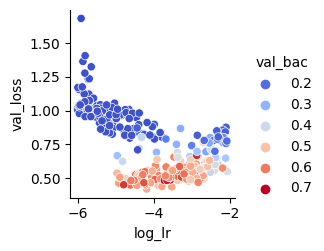

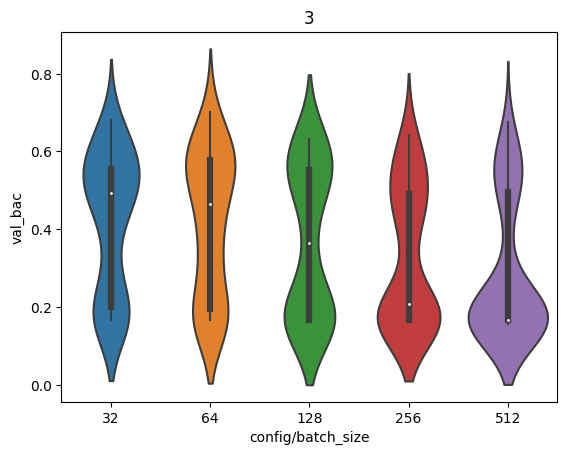

In [120]:
# For all 
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round2/cv_{i}_RayTune_df.pt")], axis=0)
df = df.assign(log_lr = np.log10(df["config/lr"]))
sns.pairplot(data=df, x_vars=["config/batch_size","log_lr"], 
             y_vars="val_loss", hue="val_bac", palette="coolwarm")
plt.show()
sns.violinplot(x="config/batch_size", y="val_bac", data=df).set(title=str(i))
plt.show()

Text(0.5, 1.02, 'KDE plot of top 10% trails')

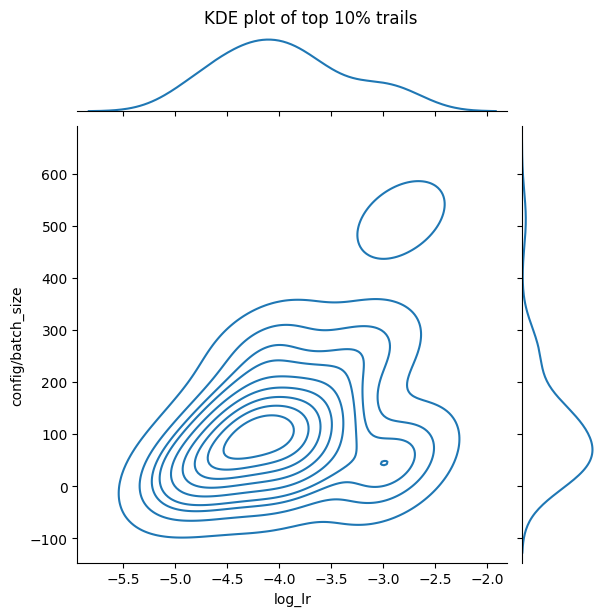

In [131]:
# For top 10%:
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round2/cv_{i}_RayTune_df.pt")], axis=0)
df = df.assign(log_lr = np.log10(df["config/lr"]))
df = df.sort_values("val_loss").iloc[:df.shape[0]//10,]
fig1 = sns.jointplot(x="log_lr", y="config/batch_size", data=df, kind='kde')
fig1.fig.suptitle("KDE plot of top 10% trails", y=1.02)

# > lr = 5e-5, batch_size=128

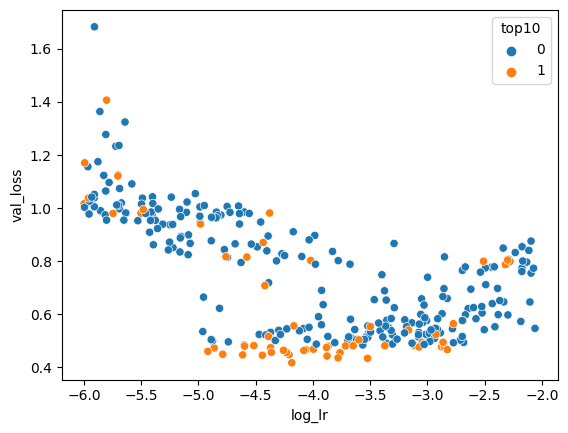

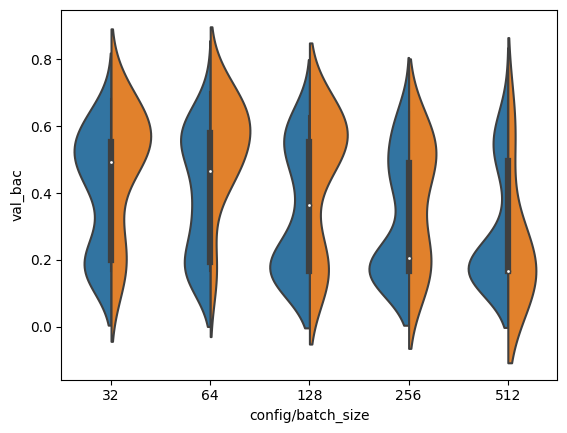

In [132]:
## Grouped by top 10% and the rest
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round2/cv_{i}_RayTune_df.pt")], axis=0)
df = df.assign(log_lr=np.log10(df["config/lr"]))

# Identify the top 10% with lowest validation loss
top10_val_loss = df.sort_values("val_loss").iloc[:int(len(df)*0.1)]
df["top10"] = np.where(df.index.isin(top10_val_loss.index), 1, 0)
# Create the pairplot with color based on validation loss
sns.scatterplot(data=df, x="log_lr", y="val_loss", hue="top10")
plt.show()

# Create the violin plot with color based on validation BAC
sns.violinplot(x="config/batch_size", y="val_bac", data=df, 
               hue="top10", split=True)
plt.legend([],[], frameon=False)
plt.show()

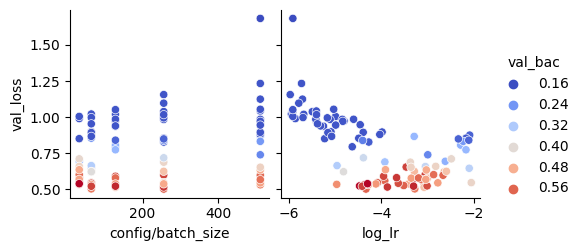

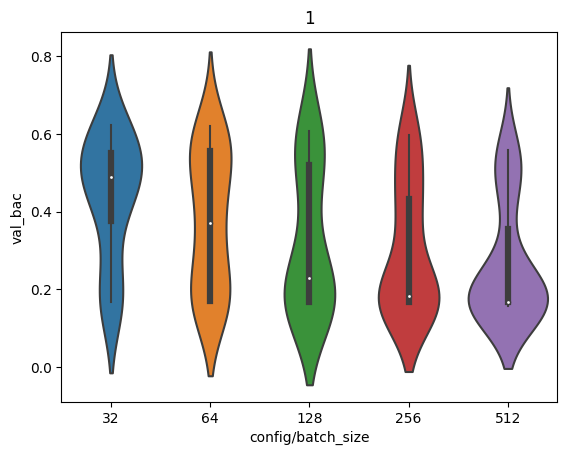

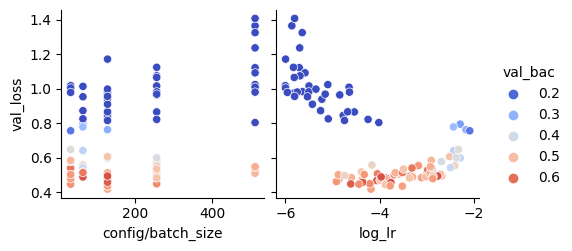

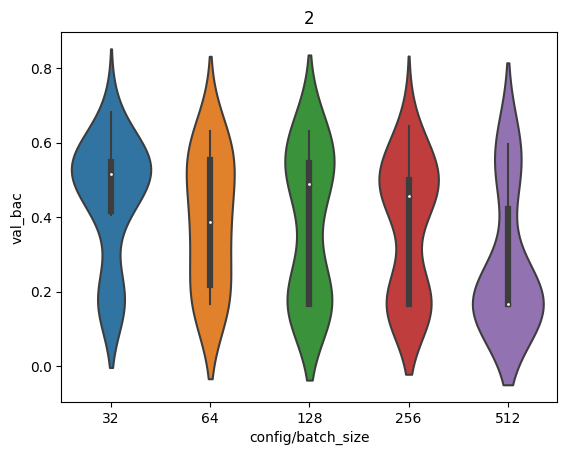

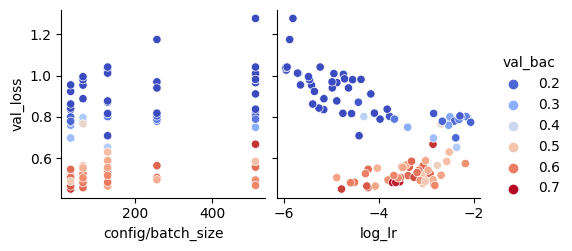

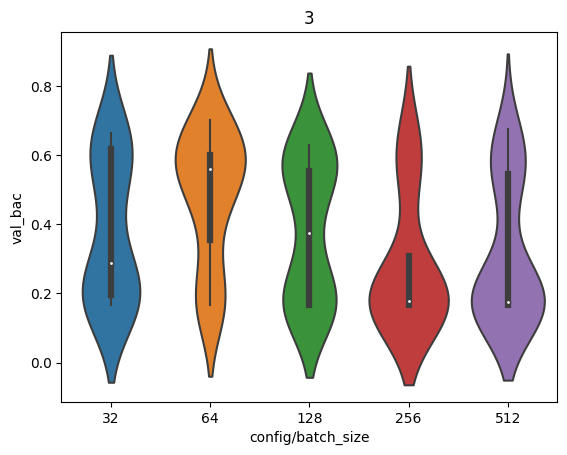

In [11]:
for i in range(1,4):
    df = torch.load(f"output/round2/cv_{i}_RayTune_df.pt")
    df = df.assign(log_lr = np.log10(df["config/lr"]))
    sns.pairplot(data=df, x_vars=["config/batch_size","log_lr"], 
             y_vars="val_loss", hue="val_bac", palette="coolwarm")
    plt.show()
    sns.violinplot(x="config/batch_size", y="val_bac", data=df).set(title=str(i))
    plt.show()
# > lr = 1e-4
# > batch_size=128

,train_loss,train_acc,train_bac,val_loss,val_acc,val_bac,time_this_iter_s,done,timesteps_total,episodes_total,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,experiment_tag,config/lr,config/batch_size
trial_id,,,,,,,,,,,,,,,,,,,,,
8b013_00041,0.432510,0.836890,0.599632,0.502725,0.774390,0.560355,1.988759,True,None,None,...,1002204,gr010.hpc.nyu.edu,10.32.35.74,121.906422,0,59,0.003262,"41_batch_size=256,lr=0.0000",0.000047,256
8b013_00014,0.327604,0.857470,0.676682,0.503920,0.788110,0.538205,2.497013,True,None,None,...,995321,gr010.hpc.nyu.edu,10.32.35.74,44.470569,0,20,0.003197,"14_batch_size=64,lr=0.0005",0.000526,64
8b013_00032,0.381060,0.839177,0.621639,0.514978,0.785061,0.451089,2.196250,True,None,None,...,999897,gr010.hpc.nyu.edu,10.32.35.74,49.687329,0,22,0.003141,"32_batch_size=128,lr=0.0008",0.000836,128
8b013_00042,0.365631,0.849848,0.640311,0.516725,0.771341,0.598179,2.158060,True,None,None,...,1002869,gr010.hpc.nyu.edu,10.32.35.74,80.026898,0,40,0.003125,"42_batch_size=256,lr=0.0001",0.000135,256
8b013_00092,0.316703,0.872713,0.707834,0.522235,0.783537,0.588212,2.367232,True,None,None,...,1013195,gr010.hpc.nyu.edu,10.32.35.74,94.209748,0,42,0.003202,"92_batch_size=64,lr=0.0000",0.000039,64
8b013_00099,0.369067,0.843750,0.627784,0.522691,0.786585,0.606483,1.119877,True,None,None,...,1014871,gr010.hpc.nyu.edu,10.32.35.74,40.158495,0,20,0.003264,"99_batch_size=128,lr=0.0005",0.000496,128
8b013_00055,0.328915,0.874238,0.699255,0.524453,0.774390,0.621804,2.647833,True,None,None,...,1005216,gr010.hpc.nyu.edu,10.32.35.74,105.216875,0,46,0.003373,"55_batch_size=64,lr=0.0000",0.000034,64
8b013_00035,0.336525,0.833841,0.617583,0.524699,0.772866,0.578513,2.345327,True,None,None,...,1000775,gr010.hpc.nyu.edu,10.32.35.74,63.424969,0,27,0.003240,"35_batch_size=256,lr=0.0010",0.000971,256
8b013_00071,0.301124,0.862043,0.683469,0.526990,0.794207,0.563736,2.104201,True,None,None,...,1008215,gr010.hpc.nyu.edu,10.32.35.74,53.886856,0,22,0.003396,"71_batch_size=64,lr=0.0003",0.000304,64


100


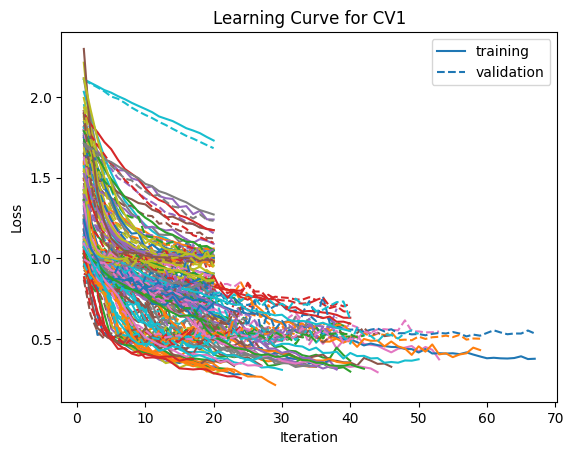

,train_loss,train_acc,train_bac,val_loss,val_acc,val_bac,time_this_iter_s,done,timesteps_total,episodes_total,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,experiment_tag,config/lr,config/batch_size
trial_id,,,,,,,,,,,,,,,,,,,,,
aec47_00007,0.337236,0.865091,0.665567,0.417475,0.807927,0.543616,2.397288,True,None,None,...,849336,gr035.hpc.nyu.edu,10.32.35.94,114.172320,0,50,0.003343,"7_batch_size=128,lr=0.0001",0.000065,128
aec47_00029,0.361059,0.841463,0.627918,0.434283,0.804878,0.544410,2.054986,True,None,None,...,853965,gr035.hpc.nyu.edu,10.32.35.94,55.275687,0,27,0.003351,"29_batch_size=128,lr=0.0003",0.000300,128
aec47_00079,0.327391,0.865854,0.712462,0.436042,0.798780,0.548524,2.395633,True,None,None,...,863879,gr035.hpc.nyu.edu,10.32.35.94,79.556122,0,33,0.003292,"79_batch_size=128,lr=0.0002",0.000166,128
aec47_00063,0.363450,0.849085,0.629506,0.442920,0.791159,0.494199,2.285248,True,None,None,...,860785,gr035.hpc.nyu.edu,10.32.35.94,70.232330,0,32,0.003297,"63_batch_size=128,lr=0.0001",0.000133,128
aec47_00082,0.365549,0.846037,0.664143,0.445668,0.798780,0.560653,2.619822,True,None,None,...,864536,gr035.hpc.nyu.edu,10.32.35.94,104.764526,0,37,0.003296,"82_batch_size=32,lr=0.0000",0.000036,32
aec47_00073,0.349268,0.855945,0.682477,0.447279,0.804878,0.617853,3.152287,True,None,None,...,862710,gr035.hpc.nyu.edu,10.32.35.94,140.273608,0,48,0.003337,"73_batch_size=32,lr=0.0000",0.000024,32
aec47_00056,0.383240,0.835366,0.599381,0.448022,0.810976,0.570302,2.281868,True,None,None,...,859240,gr035.hpc.nyu.edu,10.32.35.94,115.312693,0,58,0.003209,"56_batch_size=256,lr=0.0001",0.000062,256
aec47_00078,0.330452,0.852134,0.661710,0.455047,0.803354,0.629073,2.390186,True,None,None,...,863727,gr035.hpc.nyu.edu,10.32.35.94,72.059576,0,31,0.003321,"78_batch_size=128,lr=0.0002",0.000172,128
aec47_00080,0.349235,0.858232,0.664074,0.456933,0.820122,0.619487,2.056949,True,None,None,...,864116,gr035.hpc.nyu.edu,10.32.35.94,138.536556,0,64,0.003266,"80_batch_size=128,lr=0.0000",0.000043,128


100


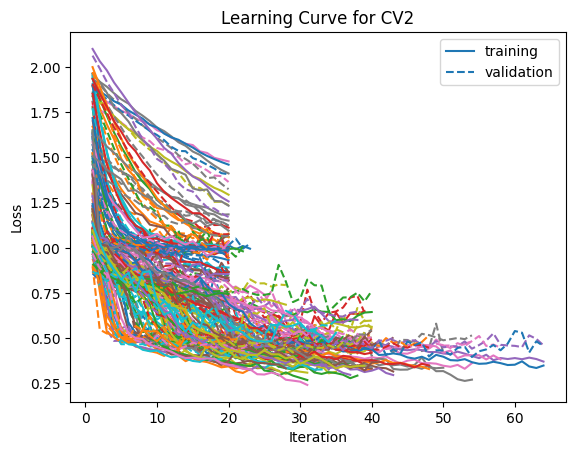

,train_loss,train_acc,train_bac,val_loss,val_acc,val_bac,time_this_iter_s,done,timesteps_total,episodes_total,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,experiment_tag,config/lr,config/batch_size
trial_id,,,,,,,,,,,,,,,,,,,,,
aec47_00017,0.358067,0.858232,0.675054,0.449480,0.812500,0.665389,3.137166,True,None,None,...,2102417,gr037.hpc.nyu.edu,10.32.35.96,135.805291,0,52,0.002930,"17_batch_size=32,lr=0.0000",0.000016,32
aec47_00046,0.346501,0.862043,0.713209,0.456044,0.801829,0.627822,2.621068,True,None,None,...,2109928,gr037.hpc.nyu.edu,10.32.35.96,71.238553,0,32,0.003158,"46_batch_size=64,lr=0.0001",0.000059,64
aec47_00025,0.338498,0.859756,0.680075,0.463783,0.794207,0.552917,2.490968,True,None,None,...,2105309,gr037.hpc.nyu.edu,10.32.35.96,77.226303,0,35,0.002987,"25_batch_size=128,lr=0.0001",0.000083,128
aec47_00070,0.284189,0.882622,0.748300,0.464322,0.807927,0.642931,2.858243,True,None,None,...,2114947,gr037.hpc.nyu.edu,10.32.35.96,88.017477,0,32,0.003077,"70_batch_size=32,lr=0.0001",0.000055,32
aec47_00084,0.343650,0.839939,0.617404,0.467040,0.804878,0.590718,2.044860,True,None,None,...,2117857,gr037.hpc.nyu.edu,10.32.35.96,76.241991,0,36,0.003007,"84_batch_size=512,lr=0.0015",0.001491,512
aec47_00024,0.351017,0.846037,0.667208,0.476824,0.792683,0.515702,1.382312,True,None,None,...,2104921,gr037.hpc.nyu.edu,10.32.35.96,57.611073,0,23,0.002983,"24_batch_size=32,lr=0.0008",0.000845,32
aec47_00035,0.400820,0.820122,0.641200,0.477590,0.774390,0.591285,2.718750,True,None,None,...,2107580,gr037.hpc.nyu.edu,10.32.35.96,37.689920,0,16,0.003172,"35_batch_size=64,lr=0.0014",0.001404,64
aec47_00071,0.333997,0.865091,0.688728,0.480184,0.804878,0.599692,2.501966,True,None,None,...,2115259,gr037.hpc.nyu.edu,10.32.35.96,142.111844,0,58,0.003110,"71_batch_size=64,lr=0.0000",0.000025,64
aec47_00030,0.324027,0.857470,0.727056,0.481164,0.789634,0.701424,2.758371,True,None,None,...,2106447,gr037.hpc.nyu.edu,10.32.35.96,55.896442,0,22,0.003085,"30_batch_size=64,lr=0.0002",0.000193,64


100


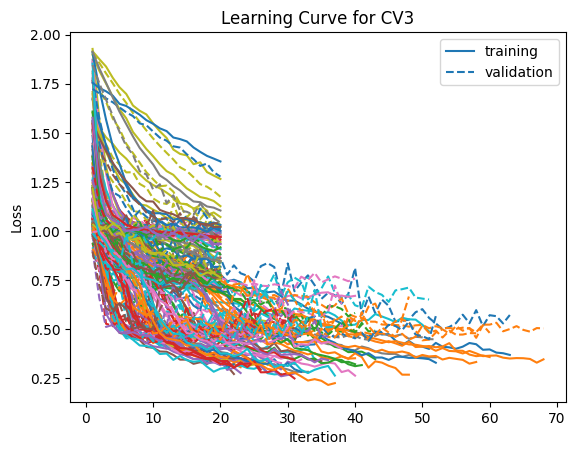

In [124]:
top=100
for i in range(1,4):
    raw = torch.load(f"output/round2/cv_{i}_RayTune.pt") 
    all_reports = raw.trial_dataframes   # get tune.report() of all iterations
    df = torch.load(f"output/round2/cv_{i}_RayTune_df.pt").sort_values("val_loss")
    display(df.head(10) )
    # get the ID of best trials:
    top_labels = df.experiment_tag.apply(lambda x:"_".join(x.split("_")[1:]))[:top]
    print(len(top_labels))
    fig, ax = plt.subplots()
    j = 0
    for key in all_reports.keys():
        label = "_".join(key.split('/')[-1].split('_')[-4:-2])
        if label in list(top_labels): # if in top trials, plot it
            color = f"C{j}"
            j += 1
            x = all_reports[key]["iterations_since_restore"]
            train_loss = all_reports[key]['train_loss']
            val_loss = all_reports[key]['val_loss']
            ax.plot(x, train_loss, label=label,
                    color=color)  # Use dashed line for train loss
            ax.plot(x, val_loss, color=color, linestyle="--")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title(f"Learning Curve for CV{i}")
    h = plt.gca().get_lines()
    lg = plt.legend(handles=h, labels=['training', 'validation'], loc='best')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### Round 3

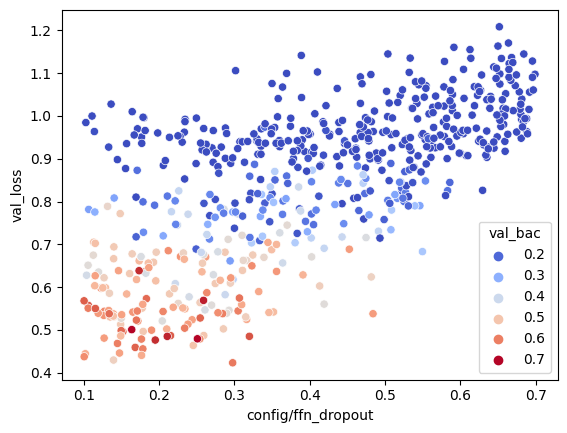

<AxesSubplot: xlabel='config/n_blocks', ylabel='val_bac'>

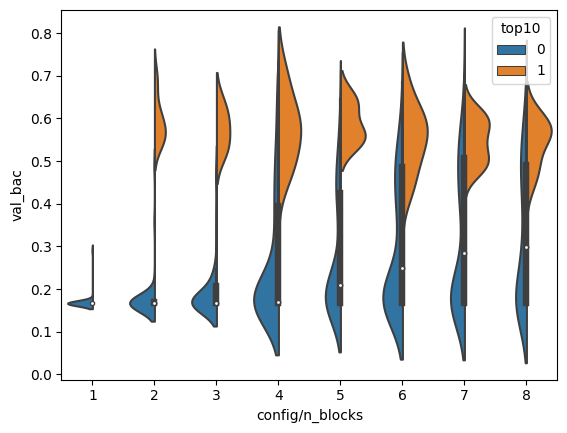

In [11]:
# For all 
df = pd.DataFrame()
for i in range(1,4):
    df = pd.concat([df, torch.load(f"output/round3/cv_{i}_RayTune_df.pt")], axis=0)
top10_val_loss = df.sort_values("val_loss").iloc[:int(len(df)*0.1)]
df["top10"] = np.where(df.index.isin(top10_val_loss.index), 1, 0)
# sns.pairplot(data=df, x_vars=["config/ffn_dropout","config/n_blocks"], 
#              y_vars="val_loss", hue="val_bac", palette="coolwarm")
sns.scatterplot(data=df, x="config/ffn_dropout", y="val_loss", hue="val_bac", palette="coolwarm")
plt.show()
sns.violinplot(x="config/n_blocks", y="val_bac", data=df, hue="top10", split=True)
# plt.show()

### Optimized model

In [144]:
optimized_model = torch.load("output/FTT_optimized_3cv_500iter.pt", map_location="cpu")
optimized_model["1"].keys()

dict_keys(['best_bac_wts', 'best_acc_wts', 'validate_acc', 'validate_bac', 'validate_losses', 'train_acc', 'train_bac', 'train_losses'])

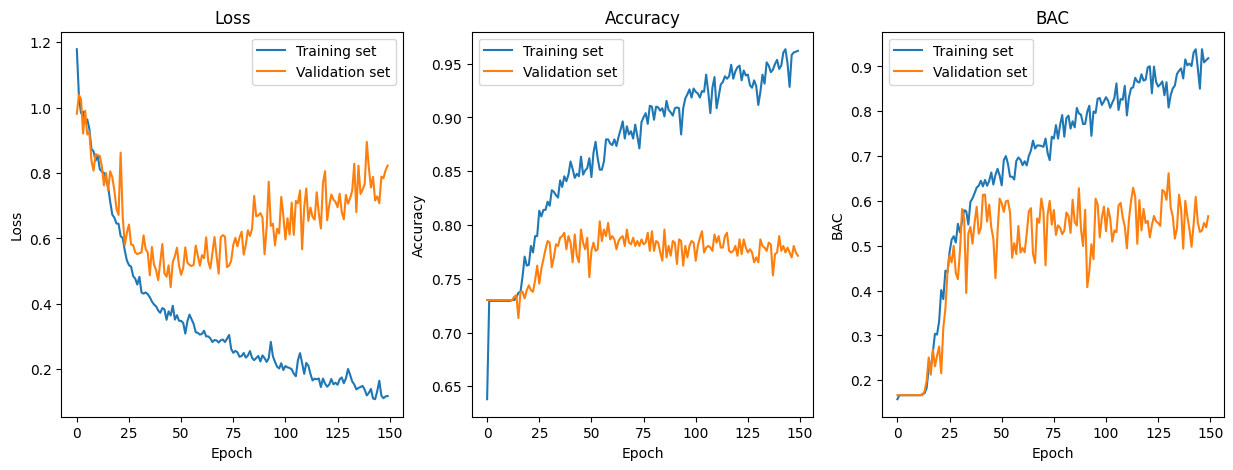

In [151]:
def plt_learning_curve(ax, train_loss, test_loss, title):
    ax.plot(train_loss, label="Training set")
    ax.plot(test_loss, label='Validation set')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.legend()

i = "1"
top = 150
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

plt_learning_curve(axs[0], optimized_model[i]["train_losses"][:top], optimized_model[i]["validate_losses"][:top], 'Loss')
plt_learning_curve(axs[1], optimized_model[i]["train_acc"][:top], optimized_model[i]["validate_acc"][:top], 'Accuracy')
plt_learning_curve(axs[2], optimized_model[i]["train_bac"][:top], optimized_model[i]["validate_bac"][:top], 'BAC')
